In [1]:
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/CINE-DENSE-Translation
%cd /home/jx8fh/Projects/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
test_fname = '/scratch/jx8fh/2024-06-22-MICCAI-ShapeMI-Workshop-data/lamod_test.npy'
test_data = np.load(test_fname, allow_pickle=True).tolist()

In [3]:
import json
config_fname = 'configs/ours-LaMoD.json'
config = json.load(open(config_fname))

In [4]:
# USE GPU 0 if available
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
config['networks']['registration']['encoder_only'] = True

In [18]:
from models.LaMoD import LaMoD
network = LaMoD(config['networks'], device).to(device)

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth


/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD/models/__init__.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model_state_dict = torch.load(pretrained_model_pat

Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth


/home/jx8fh/.conda/envs/j-voice/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Overwriting beta schedule with linear schedule with scale 30
ignorekwargs: {'type': 'DiffusionDecoder', 'drouput': 0.3, 'load_pretrained': True, 'pretrained_model_path': 'checkpoints/ours_motion_regression.pth'}
Decoder tanh_out:  False
Decoder: give_pre_end=False, tanh_out=False, out_scaling_factor=1
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
Loading pretrained model from checkpoints/ours_motion_regression.pth


In [19]:
from skimage.transform import resize
check_data_idx = 0
inference_mask = torch.from_numpy(
    resize(test_data[check_data_idx]['myo_masks'][0,0]>0.5, [48,48], anti_aliasing=False)
)

In [20]:
check_data_idx = 0

# Prepare Pytorch tensor
inference_input_video      = torch.from_numpy(test_data[check_data_idx]['myo_masks']).to(device)
inference_input_video_ori_frame = test_data[check_data_idx]['ori_n_frames']
inference_output_dict = network.inference(
    inference_input_video, 
    ori_n_frames=[inference_input_video_ori_frame],
    skip_diffusion=False)[0]

# Extract prediction
inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu()

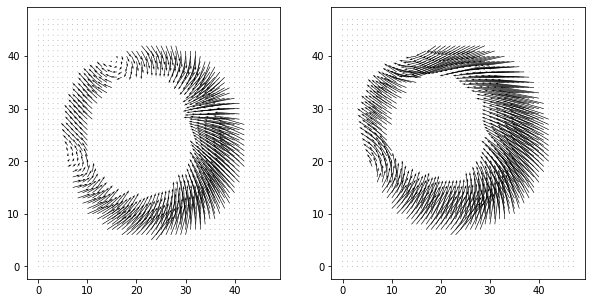

In [21]:
# Visualize 
check_frame_idx = 20
fig, axs = plt.subplots(1, 2, figsize=(10,5))
# Prediction
axs[0].quiver(
    inference_disp[0,0,check_frame_idx]*inference_mask,
    inference_disp[0,1,check_frame_idx]*inference_mask,
    units='xy',
    scale=1
)
# DENSE GT
axs[1].quiver(
    test_data[check_data_idx]['DENSE_disp'][0,check_frame_idx],
    test_data[check_data_idx]['DENSE_disp'][1,check_frame_idx],
    units='xy',
    scale=1
)